In [2]:
import numpy as np
import matplotlib.pyplot as plt
from decimal import Decimal
from IPython.display import display, Math
import csv 
from numpy import savetxt
from numpy import loadtxt
from numpy import random
from multiprocessing import Pool
from transitleastsquares import transitleastsquares
import batman
import statistics
from statistics import mode
import pandas as pd
from tabulate import tabulate


import seaborn as sns

In [ ]:
input_periods_array = np.array([])
periods_array = np.array([])
rp_over_rstar_range = np.array([])
detection_array = np.array([])
periods_array = np.array([])
FAP_array = np.array([])
periods_for_heatmap = np.array([])
ronr_for_heatmap = np.array([])
detection_for_heatmap = np.array([])
    
    
def find_period(noise, period, rp_over_rstar): #period in days
    
    global periods_array, rand_phases, detection_array, FAP_array, blue_noise
    
    #Enter parameters for star
    stellar_mass = (1/2)*(2*10**30) #half solar mass in kg
    r_star = (1/2)*(696.34*10**6) # half solar radius in meters
    
    #Enter parameters
    a= ((period**2 * 6.67 *10**-11*stellar_mass)/(4*3.1415**2))**(1/3) #meters
    period = period
    rp_over_rstar = rp_over_rstar
    a_over_rstar = a / r_star 
    inc = 90.
    print("a_over_rstar: ", a_over_rstar)
    params = [period, rp_over_rstar, a_over_rstar, inc]

    
    params = [period, rp_over_rstar, a_over_rstar]
    
    #Make Noise & time array w TESS std
    noise = pd.read_csv(str(noise))
    time = noise.iloc[:, 0].values
    time = np.array([value - time[0] for value in time]) # time start 0
    flux_err = noise.iloc[:,1].values
    std_mult = 0.010669393070550186 / np.std(flux_err)
    flux_err = (flux_err * std_mult)


     #Batman
    from matplotlib import rcParams; rcParams["figure.dpi"] = 150

    # Create test data
    time_start = 0 # time to start first transit
    data_duration = 27
    samples_per_day = 720
    samples = int(data_duration * samples_per_day)
    time = np.linspace(0, data_duration, samples)
    flux_err = flux_err[0:len(time)]

    # Use batman to create transits
    ma = batman.TransitParams()
    ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
    ma.per = period  # orbital period in days
    ma.rp = rp_over_rstar  # 6371 planet radius (in units of stellar radii)
    ma.a = a_over_rstar  # semi-major axis (in units of stellar radii)
    ma.inc = inc  # orbital inclination (in degrees)
    ma.ecc = 0.  # eccentricity
    ma.w = 0.  # longitude of periastron (in degrees)
    ma.u = [0.0, 0.0]  # limb darkening coefficients
    ma.limb_dark = "quadratic"  # limb darkening model
    m = batman.TransitModel(ma, time)  # initializes model
    synthetic_signal = m.light_curve(ma)  # calculates light curve

    # Create noise and merge with flux

    flux = synthetic_signal + flux_err

    # Plot Batman flux array (points)
    plt.figure()
    ax = plt.gca()
    ax.scatter(time, flux, color='black', s=1)
    plt.title('Simulated lightcurve')
    ax.set_ylabel("Flux")
    ax.set_xlabel("Time (days)")

    plt.plot(time, flux)

    # Running transit least squares
    leastsquares = transitleastsquares(time, flux)#binned:(time_bin, flux_bin)
    results = leastsquares.power()


    # Showing the batman plot

    plt.figure()
    ax = plt.gca()
    ax.axvline(results.period, alpha=0.4, lw=3)
    plt.xlim(np.min(results.periods), np.max(results.periods))
    for n in range(2, 10):
        ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
        ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
    plt.ylabel(r'SDE')
    plt.xlabel('Period (days)')
    plt.plot(results.periods, results.power, color='black', lw=0.5)
    plt.xlim(0, max(results.periods))

    periods_array = np.append(periods_array, results.period)
    FAP_array = np.append(FAP_array,results.FAP) #if greater than 10^(-4)
    
    return FAP_array

    if results.FAP < .0001 and period *.99 < results.period < period* 1.01:
        detection_array = np.append(detection_array, 1)
    else:
        detection_array = np.append(detection_array, 0)

#generate n periods
period = -3 #INITIAL
how_many_periods = int(input("How many periods? "))

for x in range(0,how_many_periods):
    period = period + 5
    input_periods_array = np.append(input_periods_array, period)
print(input_periods_array)
    
#generate n rp_over_rstars
rp_over_rstar = .1 #INITIAL
how_many_rp_over_rstars = int(input("How many rp_over_rstars? "))

for x in range(0,how_many_rp_over_rstars):
    rp_over_rstar = rp_over_rstar + .0005
    rp_over_rstar_range = np.append(rp_over_rstar_range, rp_over_rstar)
print(rp_over_rstar_range)
    
#input noise
noise = str(input('noise_file: (fake_data_autocor_tau1.csv, fake_data_autocor_tau1.5.csv, fake_data_autocor_tau2.csv)'))

    
#run TLS n times for each pair 
times_to_run_each_block = input("How many times to run each block? ")

for x in input_periods_array:
    for y in rp_over_rstar_range:
        for each in range (0,1):
            find_period(noise, x, y)
        periods_for_heatmap = np.append(periods_for_heatmap, x)
        ronr_for_heatmap = np.append(ronr_for_heatmap, y)
        detection_percent = sum(detection_array) / 10
        detection_for_heatmap = np.append(detection_for_heatmap, detection_percent)
        print(detection_array)
        detection_array = ([])

        
        
print(periods_for_heatmap)
print()
print(ronr_for_heatmap)
print(detection_for_heatmap)
#print(FAP_array)

How many periods?  2


[2. 7.]


How many rp_over_rstars?  2


[0.1005 0.101 ]


noise_file: (fake_data_autocor_tau1.csv, fake_data_autocor_tau1.5.csv, fake_data_autocor_tau2.csv) fake_data_autocor_tau1.csv
How many times to run each block?  2


a_over_rstar:  0.005430325816261963
Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 41 durations
Searching 29986 data points, 4071 periods from 0.602 to 20.823 days
Using all 10 CPU threads



  0%|          | 0/4071 periods | 00:00<?
  0%|          | 1/4071 periods | 00:02<2:53:56
  0%|          | 8/4071 periods | 00:02<16:41  
  0%|          | 18/4071 periods | 00:02<06:23
  1%|          | 26/4071 periods | 00:02<04:01
  1%|          | 34/4071 periods | 00:03<02:49
  1%|          | 42/4071 periods | 00:03<02:09
  1%|          | 50/4071 periods | 00:03<01:48
  1%|▏         | 58/4071 periods | 00:03<01:29
  2%|▏         | 68/4071 periods | 00:03<01:13
  2%|▏         | 76/4071 periods | 00:03<01:08
  2%|▏         | 85/4071 periods | 00:03<01:00
  2%|▏         | 93/4071 periods | 00:03<00:58
  2%|▏         | 101/4071 periods | 00:03<00:59
  3%|▎         | 109/4071 periods | 00:04<00:56
  3%|▎         | 118/4071 periods | 00:04<00:55
  3%|▎         | 127/4071 periods | 00:04<00:52
  3%|▎         | 135/4071 periods | 00:04<00:53
  4%|▎         | 145/4071 periods | 00:04<00:51
  4%|▍         | 155/4071 periods | 00:04<00:49
  4%|▍         | 164/4071 periods | 00:04<00:49
  4%|▍ 

[]
a_over_rstar:  0.005430325816261963
Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 41 durations
Searching 29986 data points, 4071 periods from 0.602 to 20.823 days
Using all 10 CPU threads



  0%|          | 0/4071 periods | 00:00<?
  0%|          | 1/4071 periods | 00:02<2:58:29
  0%|          | 9/4071 periods | 00:02<15:09  
  0%|          | 19/4071 periods | 00:02<06:13
  1%|          | 30/4071 periods | 00:03<03:34
  1%|          | 39/4071 periods | 00:03<02:32
  1%|          | 48/4071 periods | 00:03<01:56
  1%|▏         | 56/4071 periods | 00:03<01:37
  2%|▏         | 66/4071 periods | 00:03<01:17
  2%|▏         | 75/4071 periods | 00:03<01:14
  2%|▏         | 83/4071 periods | 00:03<01:09
  2%|▏         | 92/4071 periods | 00:03<01:02
  2%|▏         | 100/4071 periods | 00:03<01:02
  3%|▎         | 111/4071 periods | 00:04<00:53
  3%|▎         | 121/4071 periods | 00:04<00:54
  3%|▎         | 131/4071 periods | 00:04<00:52
  3%|▎         | 139/4071 periods | 00:04<00:54
  4%|▎         | 149/4071 periods | 00:04<00:51
  4%|▍         | 157/4071 periods | 00:04<00:51
  4%|▍         | 167/4071 periods | 00:04<00:52
  4%|▍         | 176/4071 periods | 00:04<00:53
  5%|▍

[]
a_over_rstar:  0.01251808561049803
Transit Least Squares TLS 1.0.31 (22 Nov 2021)
Creating model cache for 41 durations
Searching 29986 data points, 4071 periods from 0.602 to 20.823 days
Using all 10 CPU threads



  0%|          | 0/4071 periods | 00:00<?
  0%|          | 1/4071 periods | 00:02<2:53:26
  0%|          | 8/4071 periods | 00:02<16:39  
  0%|          | 15/4071 periods | 00:02<07:47
  1%|          | 23/4071 periods | 00:02<04:27
  1%|          | 30/4071 periods | 00:02<03:08
  1%|          | 39/4071 periods | 00:03<02:17
  1%|          | 48/4071 periods | 00:03<01:43
  1%|▏         | 56/4071 periods | 00:03<01:26
  2%|▏         | 64/4071 periods | 00:03<01:19
  2%|▏         | 73/4071 periods | 00:03<01:10
  2%|▏         | 81/4071 periods | 00:03<01:08
  2%|▏         | 89/4071 periods | 00:03<01:05
  2%|▏         | 96/4071 periods | 00:03<01:06
  3%|▎         | 104/4071 periods | 00:04<01:01
  3%|▎         | 112/4071 periods | 00:04<00:59
  3%|▎         | 119/4071 periods | 00:04<00:59
  3%|▎         | 126/4071 periods | 00:04<01:06
  3%|▎         | 136/4071 periods | 00:04<00:59
  4%|▎         | 146/4071 periods | 00:04<00:54
  4%|▍         | 154/4071 periods | 00:04<00:57
  4%|▍  

periods: [2. 2. 7. 7.]
ronr: [0.0155 0.016  0.0155 0.016 ]
percent found: [0. 0. 0. 0.]


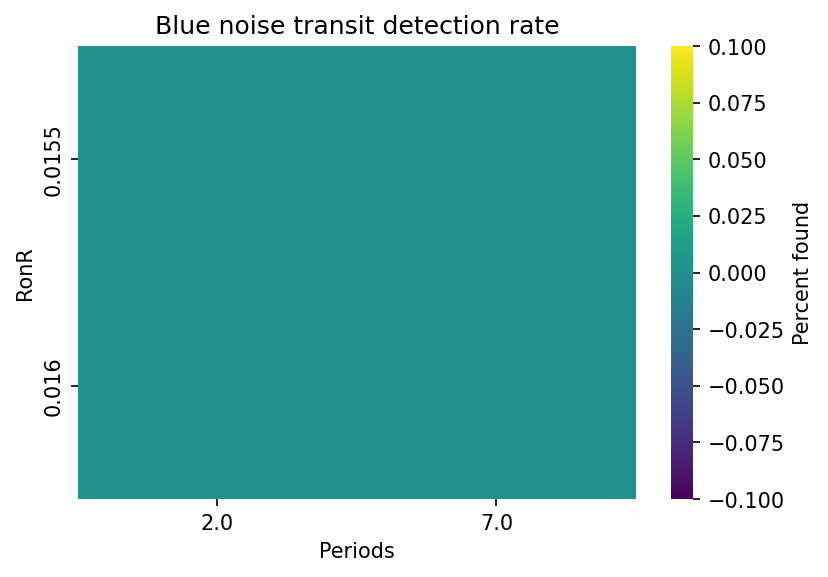

In [10]:
print("periods:" , periods_for_heatmap)
print("ronr:" , ronr_for_heatmap)
print("percent found:" , detection_for_heatmap)
#print(FAP_array)

data = pd.DataFrame({'RonR': ronr_for_heatmap, 'Periods': periods_for_heatmap, 'Detection': detection_for_heatmap})
data_pivoted = data.pivot("RonR", "Periods", "Detection")
data_pivoted = sns.heatmap(data_pivoted, cmap="viridis")
#pd.plot(kind='RonR',rot=0)

plt.title("Blue noise transit detection rate")
data_pivoted.collections[0].colorbar.set_label("Percent found")
plt.show()

In [ ]:

    #Enter parameters
    period = period
    rp_over_rstar = rp_over_rstar
    a_over_rstar =  period **(2/3) #assuming sunlike star #19.53338 if M/2 and R/2
    inc = 90.
    error_amount = 10 ** (-3) #per point error this s the transit depth of the earth around the star

    params = [period, rp_over_rstar, a_over_rstar, inc]

#     #gaussian noise array
#     flux_err = np.array([])
#     for timestep in range(1,19441):
#         noise = random.normal(0,error_amount)
#         flux_err = np.append(flux_err, noise)

    #Make colored Noise
    colored_noise = ColoredNoise(beta=-1,t=27, rng=None) #t is right hand endpoint, -1=blue 2=red 1=pink -2=violet 0=white


    cmag = error_amount /.007 #i believe the error is automatically at .007 compared to my error function, just from eyeballing
    cnoise = colored_noise.sample(19439)
    flux_err = cnoise * cmag

    #time array
    time = np.linspace(0,27,19441)


     #Batman
    from matplotlib import rcParams; rcParams["figure.dpi"] = 150

    # Create test data
    time_start = 0 # time to start first transit
    data_duration = 27
    samples_per_day = 720
    samples = int(data_duration * samples_per_day)
    time = np.linspace(0, data_duration, samples)

    # Use batman to create transits
    ma = batman.TransitParams()
    ma.t0 = time_start  # time of inferior conjunction; first transit is X days after start
    ma.per = period  # orbital period
    ma.rp = rp_over_rstar  # 6371 planet radius (in units of stellar radii)
    ma.a = a_over_rstar  # semi-major axis (in units of stellar radii)
    ma.inc = inc  # orbital inclination (in degrees)
    ma.ecc = 0.  # eccentricity
    ma.w = 0.  # longitude of periastron (in degrees)
    ma.u = [0.0, 0.0]  # limb darkening coefficients
    ma.limb_dark = "quadratic"  # limb darkening model
    m = batman.TransitModel(ma, time)  # initializes model
    synthetic_signal = m.light_curve(ma)  # calculates light curve

    # Create noise and merge with flux

    flux = synthetic_signal + flux_err

    # Plot Batman flux array (points)
    plt.figure()
    ax = plt.gca()
    ax.scatter(time, flux, color='black', s=1)
    plt.title('Simulated lightcurve (Correlated Noise)')
    ax.set_ylabel("Flux")
    ax.set_xlabel("Time (days)")

    plt.plot(time, flux)
    plt.plot(time, synthetic_signal)

    

In [ ]:
# Running transit least squares
leastsquares = transitleastsquares(time, flux)#binned:(time_bin, flux_bin) #unbinned: (time, lc_w_noise)
results = leastsquares.power()


# Showing the batman plot

plt.figure()
ax = plt.gca()
ax.axvline(results.period, alpha=0.4, lw=3)
plt.xlim(np.min(results.periods), np.max(results.periods))
for n in range(2, 10):
    ax.axvline(n*results.period, alpha=0.4, lw=1, linestyle="dashed")
    ax.axvline(results.period / n, alpha=0.4, lw=1, linestyle="dashed")
plt.ylabel(r'SDE')
plt.xlabel('Period (days)')
plt.plot(results.periods, results.power, color='black', lw=0.5)
plt.xlim(0, max(results.periods))

periods_array = np.append(periods_array, results.period)
FAP_array = np.append(FAP_array,results.FAP) #if greater than 10^(-4)

if results.FAP < .0001 and period *.99 < results.period < period* 1.01:
    detection_array = np.append(detection_array, 1)
else:
    detection_array = np.append(detection_array, 0)